## Classifier using only session data

Author: Raymond ma (raymondxma@gmail.com)

In [3]:
#open and display text file / directions
with open('./readme.txt', 'r') as f:
    get_ipython().set_next_input(f.read())

In [ ]:
The training data is pulled from raw logs. It has three columns that record user activity over time:
user_id: A hash that uniquely identifies the user.
activity_date: The date of the activity
activity_type: The type of activity

6sense would like to predict which users will purchase given the user's activities. 

Using the training data, build a model that predicts which user_id's will make a purchase in the future. Use the model to score the test data from most likely to least likely to purchase.

Please submit the following:
(1) Descibe which activity types you believe are most useful in predicting which user will purchase in the future.
(2) Provide a file containing the 1000 user_id's most likely to convert.
(3) [optional] Any work used to generate the list and/or notes you'd like to include.




The training data is pulled from raw logs. It has three columns that record user activity over time:
user_id: A hash that uniquely identifies the user.
activity_date: The date of the activity
activity_type: The type of activity

6sense would like to predict which users will purchase given the user's activities. 

Using the training data, build a model that predicts which user_id's will make a purchase in the future. Use the model to score the test data from most likely to least likely to purchase.

Please submit the following:
(1) Descibe which activity types you believe are most useful in predicting which user will purchase in the future.
(2) Provide a file containing the 1000 user_id's most likely to convert.
(3) [optional] Any work used to generate the list and/or notes you'd like to include.




In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.decomposition import PCA
from sklearn import grid_search
from sklearn import preprocessing
from sklearn.svm import SVC
from datetime import datetime
import xgboost as xgb
from bokeh.plotting import figure,show,output_notebook
from bokeh.models import Range1d
output_notebook()

%matplotlib inline

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Loading BokehJS ...

In [5]:
#load training and testing tsv and convert to pandas dataframes

raw_train_df = pd.read_csv("./takehome/training.tsv", 
                       sep='\t', header=None, 
                       names=["user", "activity_date","activity_type"])

train_df = pd.read_csv("./takehome/training.tsv", 
                       sep='\t', header=None, 
                       names=["user", "activity_date","activity_type"])

test_df = pd.read_csv("./takehome/test.tsv", 
                      sep='\t', header=None,
                      names=["user", "activity_date","activity_type"])

In [6]:
train_df.head()

,user,activity_date,activity_type
0,00002acbe042d69,2013-07-11,EmailOpen
1,00002acbe042d69,2013-07-11,FormSubmit
2,00002acbe042d69,2013-07-15,EmailOpen
3,00002acbe042d69,2013-07-17,EmailOpen
4,00002acbe042d69,2013-07-18,EmailOpen


In [7]:
train_df.activity_type.value_counts()

EmailOpen            3191732
Purchase              395031
WebVisit              384025
PageView              382263
EmailClickthrough     285568
FormSubmit            176067
CustomerSupport       103991
Name: activity_type, dtype: int64

In [8]:
#Both CustomerSupport and Purchase are found in the training set but not the test set
#purchase in the action indicative of user making a purchase in the training set.

print train_df['activity_type'].value_counts()
print "-----------------------------------"
print test_df['activity_type'].value_counts()

EmailOpen            3191732
Purchase              395031
WebVisit              384025
PageView              382263
EmailClickthrough     285568
FormSubmit            176067
CustomerSupport       103991
Name: activity_type, dtype: int64
-----------------------------------
EmailOpen            550886
WebVisit              88595
PageView              87149
EmailClickthrough     42364
FormSubmit            28765
Name: activity_type, dtype: int64


In [9]:
#check to see if any fields are NA or null
print train_df.isnull().values.any()
print test_df.isnull().values.any()

False
False


In [10]:
# looks like customersupport and purchased are synonymous. 
cs_set = set(train_df[train_df.activity_type=="CustomerSupport"].user.values)
purchased_users = set(train_df[train_df.activity_type=="Purchase"].user.values)
print len(cs_set)
print len(purchased_users)
print cs_set.difference(purchased_users)

103991
103991
set([])


In [11]:
#add column for purchased is true or not
#drop rows with action type of CustomerSupport
#drop rows with purchase type
purchased_users = set(train_df[train_df.activity_type=="Purchase"].user.values)
train_df['Purchased'] = train_df.apply(lambda x: 1 if x['user'] in purchased_users else 0, axis=1)
train_df.drop(train_df[train_df.activity_type == "CustomerSupport"].index, inplace=True)
train_df.drop(train_df[train_df.activity_type == "Purchase"].index, inplace=True)

In [12]:
#convert activity_date to datetime object
train_df.activity_date = pd.to_datetime(train_df.activity_date)
test_df.activity_date = pd.to_datetime(test_df.activity_date)

In [13]:
#One Hot Encoding for categorical column action_types
dummies_train = pd.get_dummies(train_df.activity_type, prefix="activity_").astype(int)
dummies_test = pd.get_dummies(test_df.activity_type, prefix="activity_").astype(int)

TRAIN_DF = pd.concat((train_df, dummies_train),axis=1)
TEST_DF = pd.concat((test_df, dummies_test),axis=1)

#drop activity_type from TRAIN_DF and TEST_DF
TRAIN_DF.drop('activity_type',axis=1,inplace=True)
TEST_DF.drop('activity_type',axis=1,inplace=True)

In [14]:
#aggrgate rows by user id summing up action 
#types and finding days between first activity and last activity for respective user

#agg functions probably should have combined train and test and kept track of user_ids in each category instead

def agg_time_train(x):
    diff = (x.max() - x.min()).days
    return float(diff)
#     max_date = TRAIN_DF[TRAIN_DF.user == x.user].activity_date.max()
#     min_date = TRAIN_DF[TRAIN_DF.user == x.user].activity_date.min()
    
#     return (max_date - min_date).days

def agg_time_test(x):
    max_date = TEST_DF[TEST_DF.user == x.user].activity_date.max()
    min_date = TEST_DF[TEST_DF.user == x.user].activity_date.min()
    
    return (max_date - min_date).days

def agg_purchased(x):
    if np.sum(x) > 0:
        return 1
    else:
        return 0

    
#groupby and aggregate




In [15]:
#group by aggregations we will aggregate dates separetly 
no_date_train = TRAIN_DF.groupby(['user']).agg({'Purchased': agg_purchased, 'activity__EmailClickthrough':np.sum,
                                               'activity__EmailOpen':np.sum, 'activity__FormSubmit': np.sum, 
                                               'activity__PageView':np.sum, 'activity__WebVisit': np.sum, 
                                                'activity_date': agg_time_train})
no_date_test = TEST_DF.groupby(['user']).agg({'activity__EmailClickthrough':np.sum,
                                               'activity__EmailOpen':np.sum, 'activity__FormSubmit': np.sum, 
                                               'activity__PageView':np.sum, 'activity__WebVisit': np.sum,
                                               'activity_date': agg_time_train})

no_date_train.reset_index(inplace=True)
no_date_test.reset_index(inplace=True)

In [16]:
no_date_train['total_actions'] = no_date_train['activity__EmailOpen'] + no_date_train['activity__PageView'] + \
no_date_train['activity__EmailClickthrough'] + no_date_train['activity__FormSubmit']

no_date_test['total_actions'] = no_date_test['activity__EmailOpen'] + no_date_test['activity__PageView'] + \
no_date_test['activity__EmailClickthrough'] + no_date_test['activity__FormSubmit']




/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


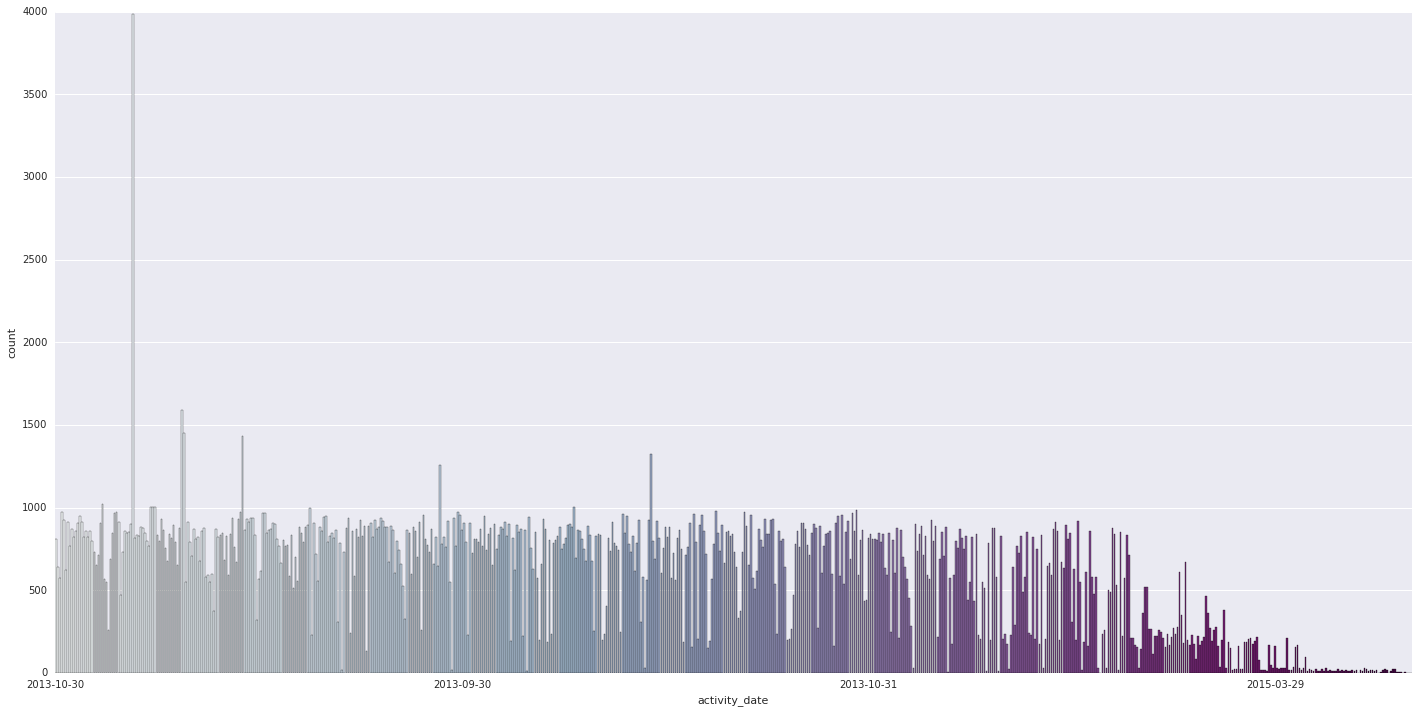

In [17]:
#data exploration using raw dataframe as training dataframe has num purchases reduced to max of 1
raw_train_df.head()
g = sns.factorplot(x="activity_date", data=raw_train_df[raw_train_df.activity_type=="Purchase"], kind="count",
                   palette="BuPu", size=10, aspect=2)
g.set_xticklabels(step=200)

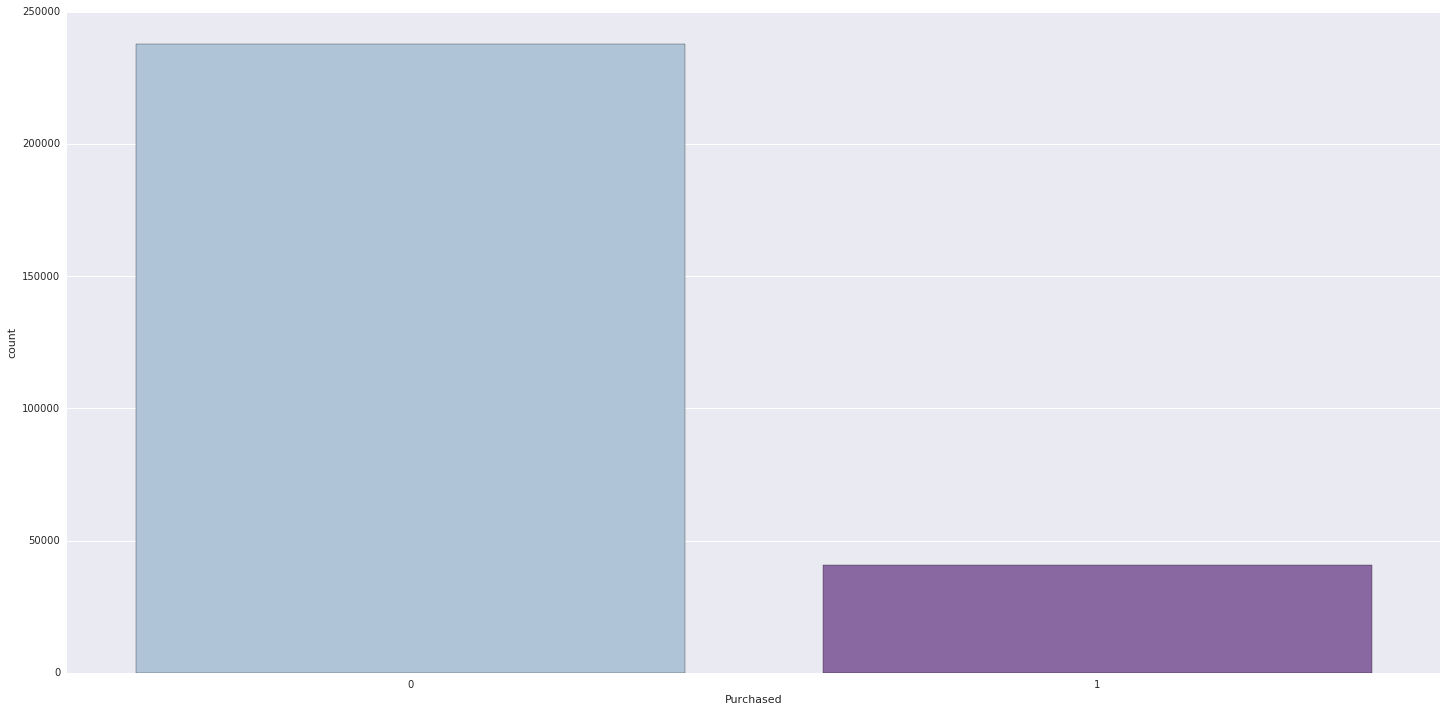

In [18]:
#class imbalance. Should probably use SMOTE or undersampling to account in future iterations.

g = sns.factorplot(x="Purchased", data= no_date_train, kind="count",
                   palette="BuPu", size=10, aspect=2)

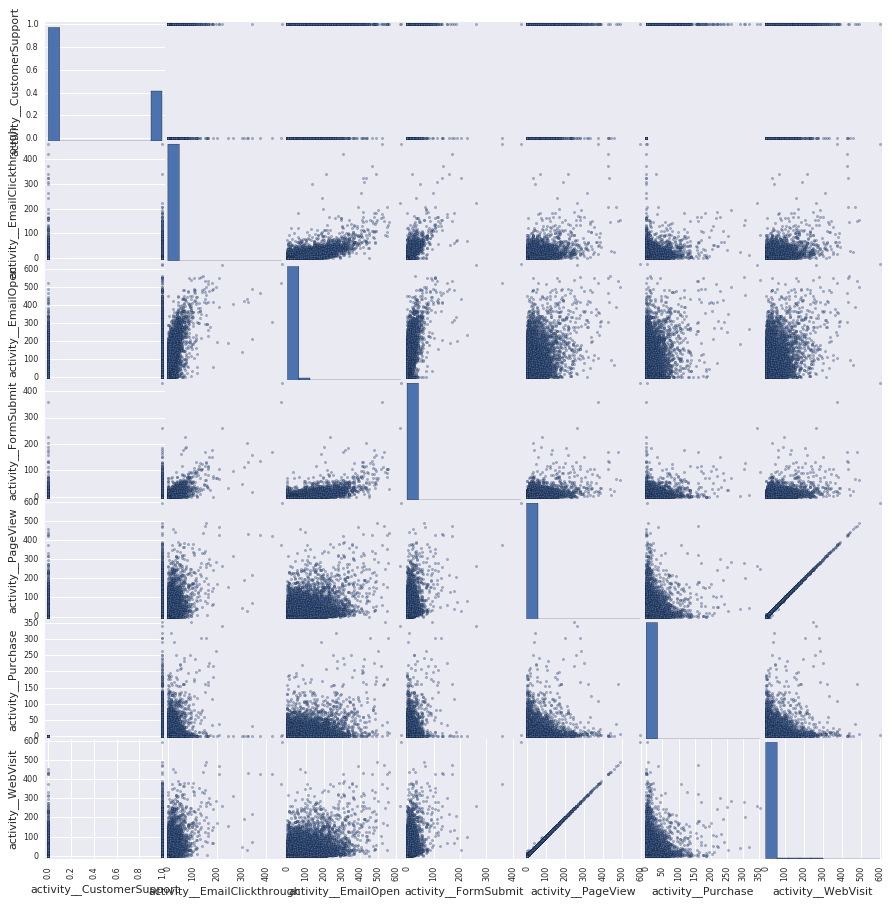

In [19]:
from pandas.tools.plotting import scatter_matrix
dummies_train_raw = pd.get_dummies(raw_train_df.activity_type, prefix="activity_").astype(int)
raw_train_df = pd.concat((raw_train_df, dummies_train_raw),axis=1)

grouped_raw = raw_train_df.groupby(['user']).agg(np.sum)
grouped_raw.reset_index(inplace=True)

'''
scatter matrix of variables show a few highly correlated variables ie pageviews and web visits
email acitvity and purchases seem to be correlated
interestingly, webvisits seem to have a negative relationship with number of purchaes.
'''

scat = scatter_matrix(grouped_raw, figsize = (15,15))

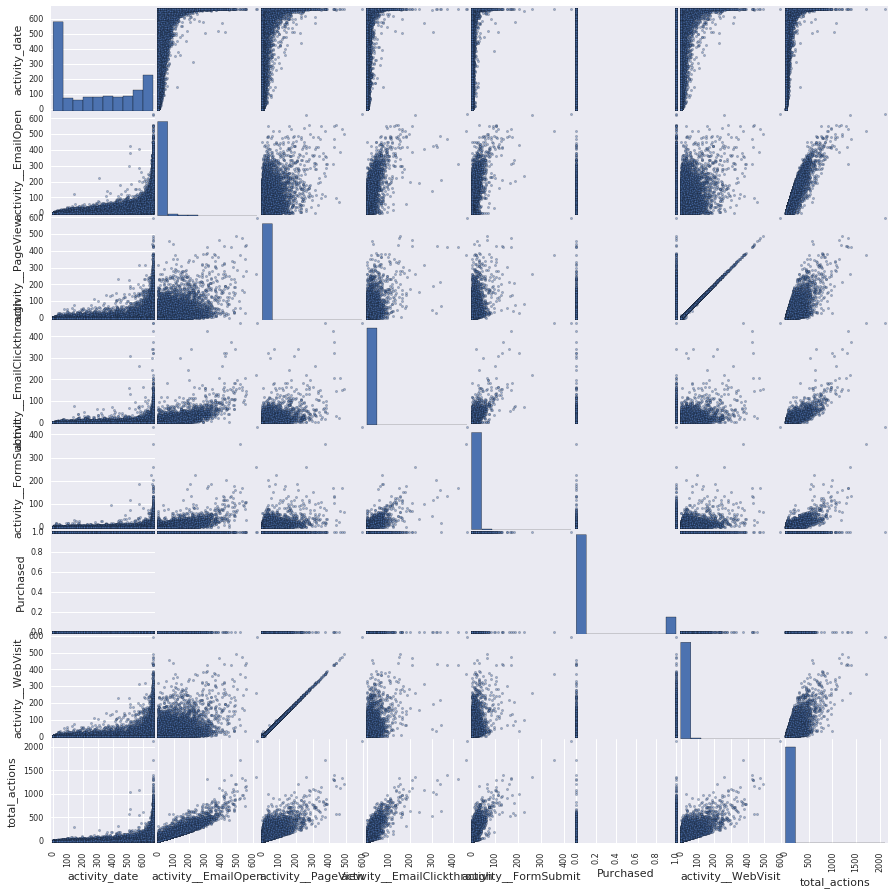

In [20]:
#scatter matrix of processed dataframe with additional number of days between first and last action of users

scat = scatter_matrix(no_date_train, figsize = (15,15))

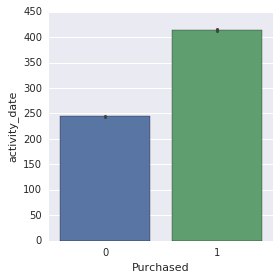

In [21]:
sns.factorplot(x="Purchased", y="activity_date", data=no_date_train, kind="bar",);

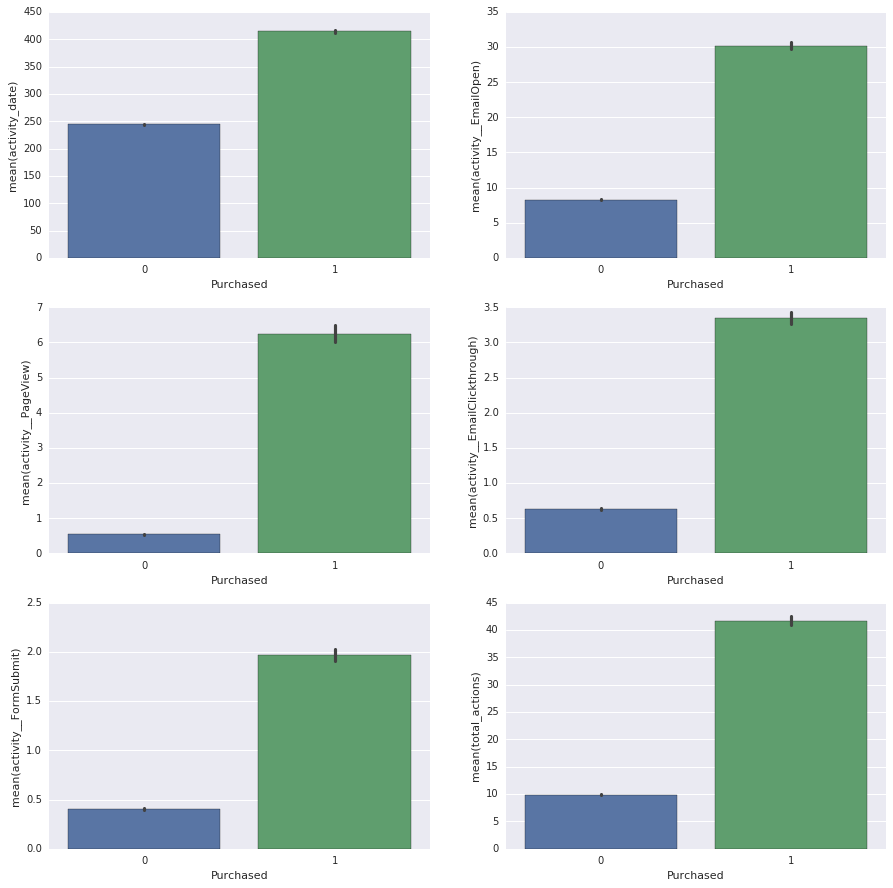

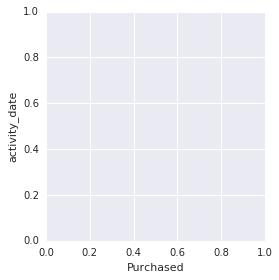

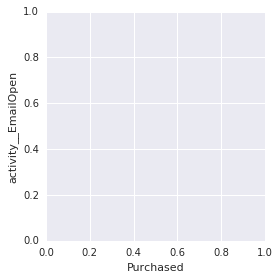

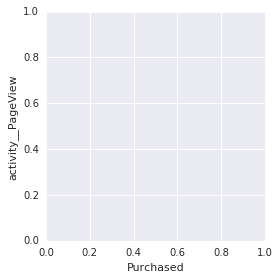

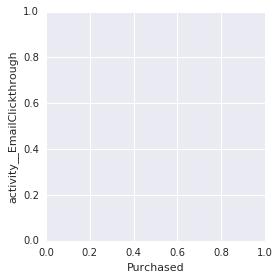

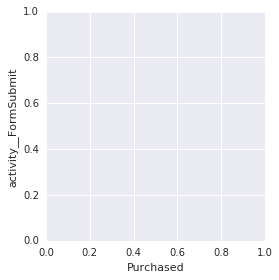

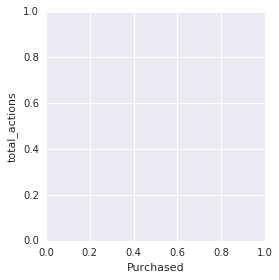

In [22]:
'''
Users who have more actions are more liekley to purchase
Users with most duration between first and last actions are likeley to purchase
a very simple model would be linear regression based on total activity count.
'''
f, axs = plt.subplots(3,2,figsize=(15,15))



sns.factorplot(x="Purchased", y="activity_date", data=no_date_train, kind="bar",ax=axs[0,0]);
sns.factorplot(x="Purchased", y="activity__EmailOpen", ax=axs[0,1], data=no_date_train, kind="bar")
sns.factorplot(x="Purchased", y="activity__PageView", ax=axs[1,0], data=no_date_train, kind="bar")
sns.factorplot(x="Purchased", y="activity__EmailClickthrough", ax=axs[1,1], data=no_date_train, kind="bar")
sns.factorplot(x="Purchased", y="activity__FormSubmit", ax=axs[2,0], data=no_date_train, kind="bar")
sns.factorplot(x="Purchased", y="total_actions", ax=axs[2,1], data=no_date_train, kind="bar")



### prep for model training

In [36]:
#drop acitivty webvisit as webvisit and pageview are highly correlated features.
# no_date_train.drop('activity__WebVisit',axis=1, inplace=True)
# no_date_test.drop('activity__WebVisit', axis=1, inplace=True)

#seperate labels and features
labels = no_date_train['Purchased']
features = no_date_train.drop(['Purchased','user'],axis=1,)

In [42]:

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2)
model = xgb.XGBClassifier(max_depth=4, learning_rate=0.3, n_estimators=200)
model.fit(X_train, Y_train)
print classification_report(Y_test,model.predict(X_test))
# print "cross val score: {}".format(cross_val_score(model, features, labels, cv=5).mean())


             precision    recall  f1-score   support

          0       0.88      0.98      0.93     47482
          1       0.65      0.19      0.30      8163

avg / total       0.84      0.87      0.83     55645



In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print confusion_matrix(Y_test,model.predict(X_test))

def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    
    p = figure(title='Receiver Operating Characteristic')
    # Plot ROC curve
    p.line(x=fpr,y=tpr,legend='ROC curve (area = %0.3f)' % roc_auc)
    p.x_range=Range1d(0,1)
    p.y_range=Range1d(0,1)
    p.xaxis.axis_label='False Positive Rate or (1 - Specifity)'
    p.yaxis.axis_label='True Positive Rate or (Sensitivity)'
    p.legend.orientation = "bottom_right"
    show(p)

target_predicted_proba = model.predict_proba(X_test)
# plot_roc_curve(Y_test, target_predicted_proba)

target_predicted_proba = model.predict_proba(X_test)
plot_roc_curve(Y_test, target_predicted_proba)

In [ ]:
# #predict on test set 

# features_test = no_date_test.drop(['user'],axis=1,)

# #train model on all training data
# model = xgb.XGBClassifier(max_depth=3, learning_rate=0.3, n_estimators=200)
# model.fit(features,labels)

# y_pred = model.predict_proba(features_test)
# y_pred_purchased = [a[1] for a in y_pred]
# ids = no_date_test['user']
# sub = pd.DataFrame(np.column_stack((ids, y_pred_purchased)), columns=['user', 'Purchase Probability'])
# sorted_sub = sub.sort(['Purchase Probability'], ascending=False)
# sorted_sub[:1000].to_csv('sub.csv',index=False)

In [ ]:
from sklearn.preprocessing import normalize
#normalization to use for linear models
cols_to_normalize = ['activity_date','activity__EmailOpen','activity__PageView',
                     'activity__EmailClickthrough','activity__FormSubmit','total_actions']

df_norm = features.copy()

df_norm[cols_to_normalize] = normalize(df_norm[cols_to_normalize])

In [ ]:
pca = PCA(n_components = 2)

X_r = pca.fit(df_norm[cols_to_normalize]).transform(df_norm[cols_to_normalize])
y_r = labels
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))


color_mapping = {0:'red',1:'blue'}
colors = []
for value in labels:
    new_color = color_mapping[value]
    colors.append(new_color)
p = figure(title="PCA")
x_values =  X_r[:,0]
y_values =  X_r[:,1]
p.circle(x = x_values,y=y_values,size = 1,color= colors,alpha =0.5)
show(p)

In [ ]:
from sklearn.linear_model import LogisticRegression


model_lr = LogisticRegression()
X_train, X_test, Y_train, Y_test = train_test_split(features[['total_actions']], labels, test_size=0.2)
model_lr.fit(X_train, Y_train)
print classification_report(Y_test,model_lr.predict(X_test))
print "cross val score: {}".format(cross_val_score(model_lr, features[['total_actions']], labels, cv=5).mean())


In [ ]:
#email click Through
from sklearn import tree


clf = tree.DecisionTreeClassifier(max_features=2,max_depth=5)

clf.fit(features.drop('total_actions',axis=1), labels)

columns = features.drop('total_actions',axis=1).columns
for i,v in enumerate(list(clf.feature_importances_)):
    print columns[i],v


In [216]:
sub.head()

,user,no_Purchase_Probability,purchase_Prob,diff_prob
0,0000ecf58c94668,0.903602,0.0963979,-0.807204
1,000132f21724ee2,0.919805,0.0801949,-0.83961
2,0001b315b991cf0,0.915315,0.0846848,-0.83063
3,000269150971d08,0.913754,0.0862458,-0.827508
4,000297ba4fa5026,0.917087,0.082913,-0.834174
